<a href="https://colab.research.google.com/github/BrittonWinterrose/DS-Unit-4-Sprint-3-Neural-Networks/blob/master/DS43SC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks Sprint Challenge

## 1) Define the following terms:

- Neuron
- Input Layer
- Hidden Layer
- Output Layer
- Activation
- Backpropagation

* Neuron: A Neuron is a brain / nerve cell that serves as a logic gate in our Brain. An Artificial Neuron is a mathematical function model of the cell. It calculates some equations on the input and decides to return a 1 or 0. In similar fashion a brain neuron receives multiple stimuli and then triggers the sending of a signal when appropriate (and sometimes when not appropriate).

* Input layer: The input layer is the input variables, sometimes called the "visable layer".

* Hidden Layer: The one or more processing layers of varying sizes and configurations that make up the MLP or deep learning model. Hidden layers are required if and only if the data must be separated non-linearly. By adding additional layers we can handle increasingly complex data relationships .

* Output Layer: The collection of output nodes that are responsible for computations and transferring information from the network to the outside world. These evaluate the combinations from the weights and hidden layer outputs and assign a final score. 

* Activation: Activation functions are used to determine how an input signal is pushed forward by a node. It does this by applying the activation function which maps the input value against an established thresholding function that constrains the output within the desired range (usually 0, 1 or -1, 1). By doing so each node can then produce a constrained output.

* Backpropagation:  In backpropagation we take the error (the "cost" that we compute by comparing the calculated output and the known, correct target output) and we then use it to update the model parameters. We calculate the total error at the output nodes and propagate these errors back through the network in each layer. This causes our network to perform better when calculating gradients than before since the weights have now been adjusted to minimize the error in prediction.

## 2) Create a perceptron class that can model the behavior of an AND gate. You can use the following table as your training data:

| x1 | x2 | x3 | y |
|----|----|----|---|
| 1  | 1  | 1  | 1 |
| 1  | 0  | 1  | 0 |
| 0  | 1  | 1  | 0 |
| 0  | 0  | 1  | 0 |

In [13]:
# Start by creating weights and bias
weight1 = 0.3334
weight2 = 0.3334
weight3 = 0.3334
bias = -1


# Add inputs and outputs
test_inputs = [(1, 1, 1), (1, 0, 1), (0, 1, 1), (0, 0, 1), (1, 1, 0), (1, 0, 0), (0,0,0)]
correct_outputs = [True, False, False, False]
outputs = []

# Generate and check output
for test_input, correct_output in zip(test_inputs, correct_outputs):
    linear_combination = weight1 * test_input[0] + weight2 * test_input[1] + weight3 * test_input[2] + bias
    output = int(linear_combination >= 0)
    is_correct_string = 'Yes' if output == correct_output else 'No'
    outputs.append([test_input[0], test_input[1],  test_input[2], linear_combination, output, is_correct_string])

# Print output
output_frame = pd.DataFrame(outputs, columns=['Input 1', '  Input 2', 'Input 3','  Linear Combination', '  Activation Output', '  Is Correct'])
print(output_frame.to_string(index=False))

Input 1    Input 2  Input 3    Linear Combination    Activation Output   Is Correct
      1          1        1                0.0002                    1          Yes
      1          0        1               -0.3332                    0          Yes
      0          1        1               -0.3332                    0          Yes
      0          0        1               -0.6666                    0          Yes


## 3) Implement a Neural Network Multilayer Perceptron class that uses backpropagation to update the network's weights. 
- Your network must have one hidden layer. 
- You do not have to update weights via gradient descent. You can use something like the derivative of the sigmoid function to update weights.
- Train your model on the Heart Disease dataset from UCI:

[Github Dataset](https://github.com/ryanleeallred/datasets/blob/master/heart.csv)

[Raw File on Github](https://raw.githubusercontent.com/ryanleeallred/datasets/master/heart.csv)


In [86]:
import pandas as pd
import numpy as np
data = "https://raw.githubusercontent.com/ryanleeallred/datasets/master/heart.csv"

df = pd.read_csv(data, header=0)
display(df.shape)
df = df.dropna(axis=0, how='any')
display(df.shape)
display(df.head(5))
display(df.target.value_counts())

display("Now we preprocess the data.")
from sklearn.preprocessing import MinMaxScaler
y = df.target.copy()
X = df.drop(columns = "target")
X = MinMaxScaler().fit_transform(X)
display(X.shape)
display(y.shape)

seed = 42


(303, 14)

(303, 14)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


1    165
0    138
Name: target, dtype: int64

'Now we preprocess the data.'

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(303, 13)

(303,)

In [0]:
import sys
import numpy as np

class NeuralNetMLP(object):
    """
    Feed forward nueral network / multi-layer perceptron classifier
    
    Parameters
    ----------
    n_hidden : int (default: 30)
        Number of hidden units
    l2 : float (default 0.)
        Lambda value for l2 normalization
    epochs : int (default: 100)
        Number of training epochs
    eta : float (default = 0.001)
        Learning rate
    shuffle : bool (default: True)
        Shuffles the training data every epoch if True
    minibatch_size : int (default : 1)
        Number of training samples per minibatch
    seed : int (default: None)
        Random seed for initalizing weights and shuffling
    
    Attributes
    ----------
    eval_ : dict
        Dictionary collecting the cost, training accuracy,
        and validation accuracy for each epoch during training
    
    """
    
    def __init__(self, n_hidden=30, l2=0.,
                epochs=100, eta=0.001,
                shuffle=True, minibatch_size=1, seed=None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        
    def _onehot(self, y, n_classes):
        """
        Encode labels into one hot representation
        
        Parameters
        ----------
        y : array, shape = [n_samples]
            Target values
        
        Returns
        -------
        onehot : array, shape = (n_samples, n_labels)
        """
        
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T
    
    def _sigmoid(self, z):
        """
        Compute logistic function (sigmoid)
        """
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def _forward(self, X):
        """
        Compute forward propogation step
        """
        # step 1: net input of hidden layer
        z_h = np.dot(X, self.w_h) + self.b_h
        
        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)
        
        # step 3: net input of output layer
        z_out = np.dot(a_h, self.w_out) + self.b_out
        
        # step 4: activation layer output
        a_out = self._sigmoid(z_out)
        
        return z_h, a_h, z_out, a_out
    
    def _compute_cost(self, y_enc, output):
        """
        Compute cost function
        
        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot encoded class labels
        output : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propoagation)
        Returns
        -------
        cost : float
            Regularized cost
        """
        e = 0.000000001
        L2_term = (self.l2 *
                  (np.sum(self.w_h ** 2.) + 
                  np.sum(self.w_out ** 2.)))
        term1 = -y_enc * (np.log(output + e))
        term2 = (1. - y_enc) * np.log(1. - output + e)
        cost = np.sum(term1 - term2) + L2_term
        return cost
    
    def predict(self, X):
        """
        Predict class labels
        
        Paramters
        ---------
        X : array, shape = [n_samples, n_features]
            Input layer with original features
        
        Returns
        -------
        y_pred : array, shape = [n_samples]
            Predicted class labels
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred
    
    def fit(self, X_train, y_train, X_valid, y_valid):
        """
        Learn weights from training data
        
        Parameters
        ----------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features
        y_train : array, shape = [n_samples]
            Target class labels
        X_test : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_test : array, shape = [n_samples]
            Samples test class labels for validation during training
            
        Returns
        -------
        self
        """
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]
        
        #######################
        # Weight Initialization
        #######################
        
        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0,
                                     scale=0.1,
                                     size=(n_features,
                                          self.n_hidden))
        
        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0,
                                       scale=0.1,
                                       size=(self.n_hidden,
                                       n_output))
        
        epoch_strlen = len(str(self.epochs)) # for progr. format
        self.eval_ = {'cost' : [],
                     'train_acc' : [],
                     'valid_acc' : []}
        
        y_train_enc = self._onehot(y_train, n_output)
        
        # iterate over training epochs
        for i in range(self.epochs):
            
            # iterate over mini batches
            indices = np.arange(X_train.shape[0])
            
            if self.shuffle:
                self.random.shuffle(indices)
            
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                
                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
                
                #################
                # Backpropagation
                #################
                
                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]
                
                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)
                
                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) * sigmoid_derivative_h)
                
                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)
                
                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)
                
                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2 * self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                
                delta_w_out = grad_w_out + self.l2 * self.w_out
                delta_b_out = grad_b_out # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
                
            ############
            # Evaluation
            ############

            # evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc, output=a_out)
            
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])
            
            sys.stderr.write('\r%0*d/%d | Cost: %.2f | Train/Valid Acc: %.2f%%/%.2f%%'
                            % (epoch_strlen, i+1, self.epochs, cost, train_acc*100, valid_acc*100))
            sys.stderr.flush()
            
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
            
        return self

In [71]:
# Test Train Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = seed)
print (X_test.shape, y_test.shape)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = .20, random_state = seed)
print (X_train.shape, y_train.shape)
print (X_valid.shape, y_valid.shape)

(61, 13) (61,)
(193, 13) (193,)
(49, 13) (49,)


1500/1500 | Cost: 133.07 | Train/Valid Acc: 87.05%/77.55%

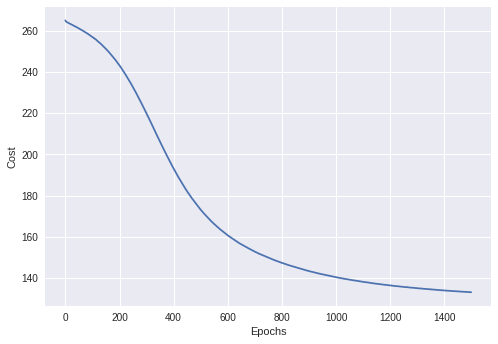

In [72]:
# Initialize a new MLP
mlp = NeuralNetMLP(n_hidden= 52,
                   l2= 0.01,
                   epochs= 1500,
                   eta= 0.0005,
                   minibatch_size= 25,
                   shuffle = True,
                   seed = 42)

# Run the MLP
mlp.fit(X_train, y_train, X_valid, y_valid)

import matplotlib.pyplot as plt
plt.plot(range(mlp.epochs), mlp.eval_['cost'])
plt.ylabel("Cost")
plt.xlabel("Epochs")
plt.show()

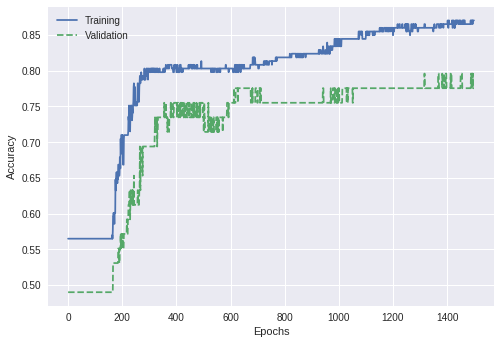

In [73]:
plt.plot(range(mlp.epochs), mlp.eval_['train_acc'], label = "Training")
plt.plot(range(mlp.epochs), mlp.eval_["valid_acc"], label = "Validation", linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [74]:
y_test_pred = mlp.predict(X_test)
acc = (np.sum(y_test == y_test_pred).astype(np.float) / X_test.shape[0])
print("Training accuracy: %.2f%%" % (acc * 100))

Training accuracy: 85.25%


## 4) Implement a Multilayer Perceptron architecture of your choosing using the Keras library. Train your model and report its baseline accuracy. Then hyperparameter tune at least two parameters and report your model's accuracy. 

- Use the Heart Disease Dataset (binary classification)
- Use an appropriate loss function for a binary classification task
- Use an appropriate activation function on the final layer of your network. 
- Train your model using verbose output for ease of grading.
- Use GridSearchCV to hyperparameter tune your model. (for at least two hyperparameters)
- When hyperparameter tuning, show you work by adding code cells for each new experiment. 
- Report the accuracy for each combination of hyperparameters as you test them so that we can easily see which resulted in the highest accuracy.
- You must hyperparameter tune at least 5 parameters in order to get a 3 on this section.

In [88]:
# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = seed)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(242, 13) (242,)
(61, 13) (61,)


In [91]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense

def baseline(optimizer = "adam", init = "uniform", activation='relu'):
  model = Sequential()
  model.add(Dense(39, input_dim=X.shape[1], activation=activation))
  model.add(Dense(39, activation=activation))
  model.add(Dense(1, activation=activation))
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=baseline, epochs=100, batch_size=5, verbose=1)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/80
193/193 [==============================] - 3s 15ms/step - loss: 1.7591 - acc: 0.4819
Epoch 2/80
193/193 [==============================] - 0s 374us/step - loss: 0.5998 - acc: 0.7098
Epoch 3/80
193/193 [==============================] - 0s 423us/step - loss: 0.5016 - acc: 0.7513
Epoch 4/80
193/193 [==============================] - 0s 373us/step - loss: 0.4528 - acc: 0.7617
Epoch 5/80
193/193 [==============================] - 0s 365us/step - loss: 0.4144 - acc: 0.7824
Epoch 6/80
193/193 [==============================] - 0s 381us/step - loss: 0.3879 - acc: 0.7927
Epoch 7/80
193/193 [==============================] - 0s 382us/step - loss: 0.3782 - acc: 0.8187
Epoch 8/80
193/193 [==============================] - 0s 364us/step - loss: 0.3611 - acc: 0.8031
Epoch 9/80
193/193 [==============================] - 0s 366us/step - loss: 0.3637 - acc: 0.8083
Epoch 10/80
193/193 [==============================] - 0s 387us/step - loss: 0.3420 - acc: 0.8342
Epoch 11/80
193/193 [=========

In [97]:
# Gridsearch Tune Optimizer
from keras.wrappers.scikit_learn import KerasClassifier

# This one will tune my inits. 
inits = ['glorot_uniform', 'normal', 'uniform']
optimizers = ['adam']
activations = ["relu"]
epochs = [100]
batches = [5]


def baseline(optimizer = "adam", init = "uniform", activation='relu'):
  model = Sequential()
  model.add(Dense(39, input_dim=X.shape[1], activation=activation))
  model.add(Dense(39, activation=activation))
  model.add(Dense(1, activation=activation))
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=baseline, verbose = 1)

param_grid = dict(optimizer=optimizers, activation=activations epochs=epochs, batch_size=batches, init=inits)
print(param_grid)
grid = GridSearchCV(estimator=model, param_grid=param_grid, )
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/100
161/161 [==============================] - 6s 36ms/step - loss: 8.9103 - acc: 0.4472
Epoch 2/100
161/161 [==============================] - 0s 579us/step - loss: 8.9100 - acc: 0.4472
Epoch 3/100
161/161 [==============================] - 0s 552us/step - loss: 8.9100 - acc: 0.4472
Epoch 4/100
161/161 [==============================] - 0s 601us/step - loss: 8.9100 - acc: 0.4472
Epoch 5/100
161/161 [==============================] - 0s 602us/step - loss: 8.9100 - acc: 0.4472
Epoch 6/100
161/161 [==============================] - 0s 630us/step - loss: 8.9100 - acc: 0.4472
Epoch 7/100
161/161 [==============================] - 0s 654us/step - loss: 8.9100 - acc: 0.4472
Epoch 8/100
161/161 [==============================] - 0s 588us/step - loss: 8.9100 - acc: 0.4472
Epoch 9/100
161/161 [==============================] - 0s 610us/step - loss: 8.9100 - acc: 0.4472
Epoch 10/100
161/161 [==============================] - 0s 589us/step - loss: 8.9100 - acc: 0.4472
Epoch 11/100
161/161

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/100
242/242 [==============================] - 6s 26ms/step - loss: 2.1200 - acc: 0.5702
Epoch 2/100
242/242 [==============================] - 0s 698us/step - loss: 0.5323 - acc: 0.7397
Epoch 3/100
242/242 [==============================] - 0s 610us/step - loss: 0.5091 - acc: 0.7975
Epoch 4/100
242/242 [==============================] - 0s 626us/step - loss: 0.4594 - acc: 0.7975
Epoch 5/100
242/242 [==============================] - 0s 609us/step - loss: 0.4541 - acc: 0.8182
Epoch 6/100
242/242 [==============================] - 0s 652us/step - loss: 0.5004 - acc: 0.8264
Epoch 7/100
242/242 [==============================] - 0s 633us/step - loss: 0.4307 - acc: 0.8182
Epoch 8/100
242/242 [==============================] - 0s 615us/step - loss: 0.4132 - acc: 0.8430
Epoch 9/100
242/242 [==============================] - 0s 636us/step - loss: 0.3953 - acc: 0.8512
Epoch 10/100
242/242 [==============================] - 0s 606us/step - loss: 0.3557 - acc: 0.8264
Epoch 11/100
242/242

In [101]:
# This one will tune my optimizers. 
inits = ['normal']
optimizers = ['rmsprop', 'adam']
activations = ["relu"]
epochs = [100]
batches = [5]

def baseline(optimizer = "adam", init = "uniform", activation='relu'):
  model = Sequential()
  model.add(Dense(39, input_dim=X.shape[1], activation=activation))
  model.add(Dense(39, activation=activation))
  model.add(Dense(1, activation=activation))
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=baseline, verbose = 1)

param_grid = dict(optimizer=optimizers, activation=activations, epochs=epochs, batch_size=batches, init=inits)
print(param_grid)
grid = GridSearchCV(estimator=model, param_grid=param_grid, )
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


{'optimizer': ['rmsprop', 'adam'], 'activation': ['relu'], 'epochs': [100], 'batch_size': [5], 'init': ['normal']}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/100
161/161 [==============================] - 8s 49ms/step - loss: 1.5479 - acc: 0.5776
Epoch 2/100
161/161 [==============================] - 0s 628us/step - loss: 0.5085 - acc: 0.7826
Epoch 3/100
161/161 [==============================] - 0s 591us/step - loss: 0.5102 - acc: 0.7764
Epoch 4/100
161/161 [==============================] - 0s 651us/step - loss: 0.4815 - acc: 0.7950
Epoch 5/100
161/161 [==============================] - 0s 648us/step - loss: 0.3863 - acc: 0.8012
Epoch 6/100
161/161 [==============================] - 0s 650us/step - loss: 0.6103 - acc: 0.8137
Epoch 7/100
161/161 [==============================] - 0s 707us/step - loss: 0.5400 - acc: 0.8261
Epoch 8/100
161/161 [==============================] - 0s 695us/step - loss: 0.4591 - acc: 0.8075
Epoch 9/100
161/161 [==============================] - 0s 629us/step - loss: 0.4194 - acc: 0.8137
Epoch 10/100
161/161 [==============================] - 0s 621us/step - loss: 0.4415 - acc: 0.8261
Epoch 11/100
161/161

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/100
242/242 [==============================] - 7s 29ms/step - loss: 0.7688 - acc: 0.5289
Epoch 2/100
242/242 [==============================] - 0s 655us/step - loss: 0.5410 - acc: 0.7190
Epoch 3/100
242/242 [==============================] - 0s 731us/step - loss: 0.5029 - acc: 0.7769
Epoch 4/100
242/242 [==============================] - 0s 700us/step - loss: 0.4481 - acc: 0.8099
Epoch 5/100
242/242 [==============================] - 0s 708us/step - loss: 0.3735 - acc: 0.8140
Epoch 6/100
242/242 [==============================] - 0s 720us/step - loss: 0.4627 - acc: 0.8347
Epoch 7/100
242/242 [==============================] - 0s 735us/step - loss: 0.5028 - acc: 0.8017
Epoch 8/100
242/242 [==============================] - 0s 722us/step - loss: 0.4843 - acc: 0.8058
Epoch 9/100
242/242 [==============================] - 0s 624us/step - loss: 0.4742 - acc: 0.7810
Epoch 10/100
242/242 [==============================] - 0s 702us/step - loss: 0.4652 - acc: 0.7562
Epoch 11/100
242/242

In [102]:
# This one will tune my activations. 
activations = ["relu", "sigmoid"]

def baseline(optimizer = "adam", init = "uniform", activation='relu'):
  model = Sequential()
  model.add(Dense(39, input_dim=X.shape[1], activation=activation))
  model.add(Dense(39, activation=activation))
  model.add(Dense(1, activation=activation))
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=baseline, epochs=100, batch_size=5, verbose=1)

param_grid = dict(activation=activations)
print(param_grid)
grid = GridSearchCV(estimator=model, param_grid=param_grid, )
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


{'activation': ['relu', 'sigmoid']}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/100
161/161 [==============================] - 8s 49ms/step - loss: 8.9101 - acc: 0.4472
Epoch 2/100
161/161 [==============================] - 0s 750us/step - loss: 8.9100 - acc: 0.4472
Epoch 3/100
161/161 [==============================] - 0s 693us/step - loss: 8.9100 - acc: 0.4472
Epoch 4/100
161/161 [==============================] - 0s 652us/step - loss: 8.9100 - acc: 0.4472
Epoch 5/100
161/161 [==============================] - 0s 707us/step - loss: 8.9100 - acc: 0.4472
Epoch 6/100
161/161 [==============================] - 0s 666us/step - loss: 8.9100 - acc: 0.4472
Epoch 7/100
161/161 [==============================] - 0s 721us/step - loss: 8.9100 - acc: 0.4472
Epoch 8/100
161/161 [==============================] - 0s 697us/step - loss: 8.9100 - acc: 0.4472
Epoch 9/100
161/161 [==============================] - 0s 728us/step - loss: 8.9100 - acc: 0.4472
Epoch 10/100
161/161 [==============================] - 0s 829us/step - loss: 8.9100 - acc: 0.4472
Epoch 11/100
161/161

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Epoch 1/100
242/242 [==============================] - 8s 32ms/step - loss: 0.6912 - acc: 0.5331
Epoch 2/100
242/242 [==============================] - 0s 662us/step - loss: 0.6786 - acc: 0.6240
Epoch 3/100
242/242 [==============================] - 0s 733us/step - loss: 0.6625 - acc: 0.5992
Epoch 4/100
242/242 [==============================] - 0s 726us/step - loss: 0.6485 - acc: 0.6033
Epoch 5/100
242/242 [==============================] - 0s 714us/step - loss: 0.6336 - acc: 0.7107
Epoch 6/100
242/242 [==============================] - 0s 708us/step - loss: 0.6119 - acc: 0.7603
Epoch 7/100
242/242 [==============================] - 0s 740us/step - loss: 0.5859 - acc: 0.7686
Epoch 8/100
242/242 [==============================] - 0s 733us/step - loss: 0.5595 - acc: 0.7727
Epoch 9/100
242/242 [==============================] - 0s 745us/step - loss: 0.5339 - acc: 0.7727
Epoch 10/100
242/242 [==============================] - 0s 743us/step - loss: 0.5109 - acc: 0.7893
Epoch 11/100
242/242

In [104]:
# This one will tune # of epochs. 
epochs = np.array([50, 100, 150])

def baseline(optimizer = "adam", init = "uniform", activation='sigmoid'):
  model = Sequential()
  model.add(Dense(39, input_dim=X.shape[1], activation=activation))
  model.add(Dense(39, activation=activation))
  model.add(Dense(1, activation=activation))
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=baseline, batch_size=5, verbose=1)

param_grid = dict(epochs=epochs)
print(param_grid)
grid = GridSearchCV(estimator=model, param_grid=param_grid, )
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


{'epochs': array([ 50, 100, 150])}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/50
161/161 [==============================] - 8s 47ms/step - loss: 0.7228 - acc: 0.5528
Epoch 2/50
161/161 [==============================] - 0s 670us/step - loss: 0.6887 - acc: 0.5528
Epoch 3/50
161/161 [==============================] - 0s 749us/step - loss: 0.6845 - acc: 0.5528
Epoch 4/50
161/161 [==============================] - 0s 675us/step - loss: 0.6833 - acc: 0.5528
Epoch 5/50
161/161 [==============================] - 0s 747us/step - loss: 0.6767 - acc: 0.5528
Epoch 6/50
161/161 [==============================] - 0s 677us/step - loss: 0.6717 - acc: 0.5528
Epoch 7/50
161/161 [==============================] - 0s 754us/step - loss: 0.6673 - acc: 0.5528
Epoch 8/50
161/161 [==============================] - 0s 668us/step - loss: 0.6628 - acc: 0.6025
Epoch 9/50
161/161 [==============================] - 0s 656us/step - loss: 0.6554 - acc: 0.5776
Epoch 10/50
161/161 [==============================] - 0s 733us/step - loss: 0.6456 - acc: 0.7143
Epoch 11/50
161/161 [=========

In [105]:
# This one will tune batch size. 
batches = np.array([5, 20])

def baseline(optimizer = "adam", init = "uniform", activation='sigmoid'):
  model = Sequential()
  model.add(Dense(39, input_dim=X.shape[1], activation=activation))
  model.add(Dense(39, activation=activation))
  model.add(Dense(1, activation=activation))
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=baseline, epochs=100, verbose=1)

param_grid = dict(batch_size=batches)
print(param_grid)
grid = GridSearchCV(estimator=model, param_grid=param_grid, )
grid_result = grid.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

{'batch_size': array([ 5, 20])}


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Epoch 1/100
161/161 [==============================] - 9s 56ms/step - loss: 0.6944 - acc: 0.5528
Epoch 2/100
161/161 [==============================] - 0s 831us/step - loss: 0.6870 - acc: 0.5528
Epoch 3/100
161/161 [==============================] - 0s 860us/step - loss: 0.6835 - acc: 0.5528
Epoch 4/100
161/161 [==============================] - 0s 819us/step - loss: 0.6782 - acc: 0.5652
Epoch 5/100
161/161 [==============================] - 0s 783us/step - loss: 0.6769 - acc: 0.6894
Epoch 6/100
161/161 [==============================] - 0s 852us/step - loss: 0.6652 - acc: 0.5590
Epoch 7/100
161/161 [==============================] - 0s 826us/step - loss: 0.6565 - acc: 0.6460
Epoch 8/100
161/161 [==============================] - 0s 815us/step - loss: 0.6471 - acc: 0.6211
Epoch 9/100
161/161 [==============================] - 0s 902us/step - loss: 0.6386 - acc: 0.7640
Epoch 10/100
161/161 [==============================] - 0s 892us/step - loss: 0.6230 - acc: 0.7205
Epoch 11/100
161/161

In [106]:
# Same as initial, but with all the GridSearched Recommendations. 

def baseline(optimizer = "adam", init = "uniform", activation='sigmoid'):
  model = Sequential()
  model.add(Dense(39, input_dim=X.shape[1], activation=activation))
  model.add(Dense(39, activation=activation))
  model.add(Dense(1, activation=activation))
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=baseline, epochs=100, batch_size=20, verbose=1)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
results = cross_val_score(model, X_train, y_train, cv=kfold)

print("Before GridSearchCV results were: 56.86% (11.32%) ")
print("With GridSearchCV finding new results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Epoch 1/100
193/193 [==============================] - 10s 50ms/step - loss: 0.7674 - acc: 0.4508
Epoch 2/100
193/193 [==============================] - 0s 234us/step - loss: 0.7096 - acc: 0.4456
Epoch 3/100
193/193 [==============================] - 0s 220us/step - loss: 0.6902 - acc: 0.5492
Epoch 4/100
193/193 [==============================] - 0s 234us/step - loss: 0.6876 - acc: 0.5492
Epoch 5/100
193/193 [==============================] - 0s 226us/step - loss: 0.6851 - acc: 0.5492
Epoch 6/100
193/193 [==============================] - 0s 224us/step - loss: 0.6832 - acc: 0.5492
Epoch 7/100
193/193 [==============================] - 0s 236us/step - loss: 0.6814 - acc: 0.5492
Epoch 8/100
193/193 [==============================] - 0s 241us/step - loss: 0.6797 - acc: 0.5492
Epoch 9/100
193/193 [==============================] - 0s 234us/step - loss: 0.6786 - acc: 0.5492
Epoch 10/100
193/193 [==============================] - 0s 250us/step - loss: 0.6764 - acc: 0.5492
Epoch 11/100
193/19